In [1]:
%matplotlib inline
import cPickle
import matplotlib.pyplot as plt
import mayavi.mlab as mlab
import numpy as np
import os
import scipy.io as sio
import scipy.ndimage.filters as filters
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
with open(r"visibility.pkl", "rb") as f:
    data = cPickle.load(f)

In [3]:
with open("2017_04_22_09_10_00_grid_0.25.pkl", "rb") as f:
    recon_data = cPickle.load(f)

In [19]:
volumes = [d.reshape(48, 48, 31) for d in data[0]]
scaling = data[1][0].reshape(48, 48, 31)
beta = recon_data[0]
volumes_sum = np.array(volumes).sum(axis=0)

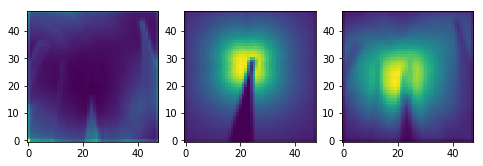

In [23]:
@interact(depth=(0, 30), ind=(0, 9))
def plot(depth, ind):
    f, axes = plt.subplots(ncols=3, figsize=(8, 24))
    axes[0].imshow(scaling[..., depth], origin="bottom", interpolation="nearest")
    axes[1].imshow(volumes[ind][..., depth], origin="bottom", interpolation="nearest")
    axes[2].imshow(volumes_sum[..., depth], origin="bottom", interpolation="nearest")
    plt.show()

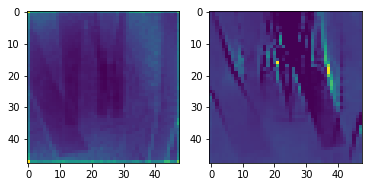

In [5]:
@interact(depth=(0, 30))
def plot(depth):
    f, axes = plt.subplots(ncols=2, figsize=(6, 12))
    axes[0].imshow(scaling[..., depth])
    axes[1].imshow(beta[..., depth])
    plt.show()

In [6]:
def weighted_laplace(vec, weights, output = None, mode = "reflect", cval = 0.0):
    """N-dimensional Laplace filter based on approximate second derivatives.

    Args:

    """

    assert vec.ndim == len(weights), 'Shape of input (%d) must equal lenght of weights (%d)' % (vec.ndim, len(weights))

    def derivative2(input, axis, output, mode, cval):
        filt = np.array((1, -2, 1)) * weights[axis]
        return filters.correlate1d(input, filt, axis, output, mode, cval, 0)

    return filters.generic_laplace(vec, derivative2, output, mode, cval)

In [7]:
beta_laplace = weighted_laplace(beta, (1., 1., 1.))
beta_grad = weighted_laplace(beta_laplace, (1., 1., 1.))

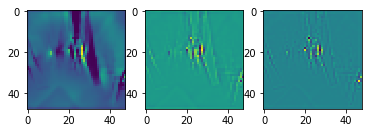

In [8]:
@interact(depth=(0, 30))
def plot(depth):
    f, axes = plt.subplots(ncols=3, figsize=(6, 18))
    axes[0].imshow(beta[..., depth])
    axes[1].imshow(beta_laplace[..., depth])
    axes[2].imshow(beta_grad[..., depth])
    plt.show()

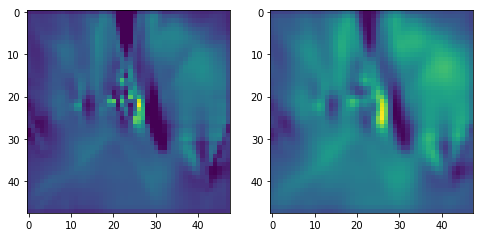

In [11]:
@interact(depth=(0, 30), iterations=(0, 50), ratio=(0.001, 0.1, 0.001))
def plot(depth, iterations, ratio):
    f, axes = plt.subplots(ncols=2, figsize=(8, 16))
    
    axes[0].imshow(beta[..., depth])
    
    smoothed_beta = beta.copy()
    for i in range(iterations):
        beta_laplace = weighted_laplace(smoothed_beta, (1., 1., 1.))
        beta_grad = weighted_laplace(beta_laplace, (1., 1., 1.))
        smoothed_beta -= ratio * beta_grad
        
    axes[1].imshow(smoothed_beta[..., depth])

    plt.show()

In [20]:
beta.shape

(48L, 48L, 31L)

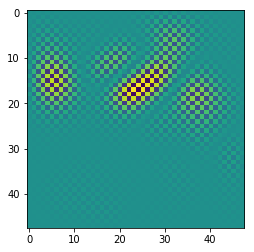

In [21]:
plt.imshow(beta[..., -1])